In [1]:
!pip install -q torch==1.9.0 torchvision
import torch
print(torch.__version__)

1.9.0+cu102


# Import Lib

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torch.optim as optim

# Data Load

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


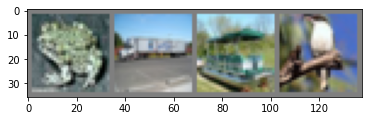

 frog truck  ship  bird
<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([6, 9, 8, 2])


In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print(type(images))
print(images.shape)
print(type(labels), labels.shape, labels)

# Hypothesis

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

# Experiment

In [46]:
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda() 
    print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        # ============== Train =============== #
        net.train()

        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # zero the parameter gradients
            optimizer.zero_grad()

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape, labels.shape)
            inputs = inputs.view(-1, 3072)

            inputs = inputs.cuda()
            labels = labels.cuda()
            # print(inputs.shape)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        # ============== Measure Val Accuracy / Val Loss ================ #
        net.eval()
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                images = images.cuda()
                labels = labels.cuda()

                # calculate outputs by running images through the network
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total

        print('Epoch: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

    # ============== Measure Test Accuracy / Test Loss ================ #
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            # calculate outputs by running images through the network
            outputs = net(images)
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    print('Finished Training')
    return train_loss, val_loss, val_acc, test_acc

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epoch = 2

# experiment(args)

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = 1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList()
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 1.872
[1,  4000] loss: 1.721
[1,  6000] loss: 1.675
[1,  8000] loss: 1.630
[1, 10000] loss: 1.622
Epoch: 0, Train Loss: 17041.807833135128, Val Loss: 1.6501373534023762, Val Acc: 41.19
